# Identification of Potential Inhibitors for Tyrosine Kinase Enzyme Using Machine Learning Part 2 - EDA & Data Pre-processing

---
**M. Alberto Moa**

In this notebook I will be performing Descriptor Calculation with Lipinski Descriptor using information from cleaned_bioactivity_data.csv from previous notebook and then conduct Exploratory Data Analysis to gain deeper insights into the factors driving biological activity.

## 1. Install and Import Libraries

Install conda and rdkit

In [13]:
! conda install -c rdkit rdkit -y

Retrieving notices: ...working... done
Channels:
 - rdkit
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.9.24  |       hca03da5_0         131 KB
    certifi-2024.8.30          |  py311hca03da5_0         165 KB
    conda-24.9.1               |  py311hca03da5_0         1.2 MB
    ------------------------------------------------------------
                                           Total:         1.5 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2024.7.4~ --> pkgs/main::ca-certificates-2024.9.24-hca03da5_0 
  certifi                          2024.7.4-py311hca03da5_0 --> 2024.8.30-py311hca03da5_0 
  conda                              24.7.1-py311hca03

In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
print('Import Success')

Import Success


## 2. Molecular Descriptor Calculation using Lipinski Descriptors

Molecular descriptors capture chemical properties of compounds and can be valuable features for building predictive models for QSAR (Quantitative Structure-Activity Relationship) models. 

In this step, I will calculate molecular descriptors based on the canonical SMILES information available in the dataset. Molecular descriptors are numerical values that represent the chemical and physical properties of molecules. These descriptors capture structural and physicochemical features, which can be valuable inputs for machine learning models.

I will use Lipinski's rule of Five which based on the observation that certain physicochemical properties correlate with the likelihood of a compound being an effective oral drug. Specifically, it proposes that a compound is more likely to be an orally bioavailable drug if it adheres to the following criteria[1]:
-  Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

### Steps:
1. Load Bioactivity Data
2. Extract **canonical SMILES** from the dataset.
3. Calculate molecular descriptors using **Lipinski Descriptorr**.
4. Merge the calculated descriptors back into the dataset for further analysis and model building.



### 1.1 Load Bioactivity Data

Load bioactivity data and save it to df variable.

In [4]:
# Load dataset
df = pd.read_csv('cleaned_bioactivity_data.csv')

# Show sample data
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,units,uo_units,value,pIC50,entry,entry_name,protein_names,organism,length,sequence
0,inactive,2206919,[],CHEMBL990554,Inhibition of Frk,B,BAO_0000034,BAO_0000357,single protein format,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,...,nM,UO_0000065,440.0,14.636491,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
1,inactive,2479571,[],CHEMBL988960,Binding affinity to human FRK,B,BAO_0000034,BAO_0000357,single protein format,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCNCC1,...,nM,UO_0000065,6.0,18.931506,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
2,inactive,2479573,[],CHEMBL988960,Binding affinity to human FRK,B,BAO_0000034,BAO_0000357,single protein format,Cc1ccc(C(=O)Nc2cccc(C(C)(C)C)c2)cc1-c1ccc(C(=O...,...,nM,UO_0000065,122.0,15.919245,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
3,inactive,2603062,[],CHEMBL1023857,Inhibition of FRK,B,BAO_0000034,BAO_0000357,single protein format,Cc1cccc(C(=O)Nc2cccc([C@H](C)Nc3cncc(Cl)n3)c2)c1,...,nM,UO_0000065,12.0,18.238359,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
4,inactive,2890919,[],CHEMBL1060247,Binding constant for FRK kinase domain,B,BAO_0000034,BAO_0000357,single protein format,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,...,nM,UO_0000065,400.0,14.731801,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,inactive,22882846,[],CHEMBL4727423,Inhibition of FRK (unknown origin),B,BAO_0000190,BAO_0000357,single protein format,COc1cc(C(=O)Nc2cc(C(F)(F)F)ccn2)ccc1-c1nc([C@@...,...,nM,UO_0000065,154.0,15.686313,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
379,inactive,22882847,[],CHEMBL4727423,Inhibition of FRK (unknown origin),B,BAO_0000190,BAO_0000357,single protein format,Nc1nccn2c([C@@H]3CC[C@H]4CCC(=O)N4C3)nc(-c3ccc...,...,nM,UO_0000065,530.0,14.450389,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
380,inactive,24407194,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5045161,Inhibition of human PTK5 in presence of ATP by...,B,BAO_0000190,BAO_0000357,single protein format,Cc1cc(NC(=O)Nc2cc(C(C)(C)C)nn2-c2ccc(Cl)cc2)cc...,...,nM,UO_0000065,32.0,17.257530,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...
381,inactive,24958174,"[{'comments': None, 'relation': None, 'result_...",CHEMBL5213173,Selectivity interaction (Z鈥�LYTE assay (Select...,B,BAO_0000192,BAO_0000357,single protein format,C[C@H]1Oc2cc(cnc2N)-c2c(nn(C)c2C#N)CN(C)C(=O)c...,...,nM,UO_0000065,53.0,16.752974,P42685,FRK_HUMAN,Tyrosine-protein kinase FRK,Homo sapiens (Human),505,MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHY...


### 1.2 Calculate Lipinski Despcriptors

In [5]:
# Define Lipinski function to calculate the descriptors
def lipinski(smiles_list):
    '''
    Calculate Lipinski descriptor for a list of SMILES strings.
    
    pArameter:
    smiles_list: List containing SMILES strings of the compounds.
    
    Returns:
    pd.DataDrame: DataFrame containing Lipinski descriptors for each SMILES string.
    '''
    
    # Initiate list to store descriptor values
    mw_list = []
    logp_list = []
    hbd_list = []
    hba_list = []
    
    # Process each SMILE string
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        
        if mol:
            # Calculate descriptors
            mw_list.append(Descriptors.MolWt(mol))
            logp_list.append(Descriptors.MolLogP(mol))
            hbd_list.append(Descriptors.NumHDonors(mol))
            hba_list.append(Descriptors.NumHAcceptors(mol))
        else:
            # Handle invalid SMILES by appending Nan
            mw_list.append(np.nan)
            logp_list.append(np.nan)
            hbd_list.append(np.nan)
            hba_list.append(np.nan)
    
    # Create DataFrame with calculated descriptors
    descriptors_df = pd.DataFrame({
        "canonical_smiles": smiles_list,
        "mw": mw_list,
        "logP": logp_list,
        "numHdonors": hbd_list,
        "numHacceptors": hba_list
    })
    
    return descriptors_df

In [6]:
# Calculate lipinski descriptor
df_lipinski = lipinski(df.canonical_smiles)

In [7]:
# Show sample data of df_lipinski dataset
df_lipinski

,canonical_smiles,mw,logP,numHdonors,numHacceptors
0,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,464.831,5.54970,3,4
1,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCNCC1,309.373,2.31060,3,6
2,Cc1ccc(C(=O)Nc2cccc(C(C)(C)C)c2)cc1-c1ccc(C(=O...,440.587,6.35162,2,2
3,Cc1cccc(C(=O)Nc2cccc([C@H](C)Nc3cncc(Cl)n3)c2)c1,366.852,4.86382,2,4
4,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,375.407,4.90362,4,3
...,...,...,...,...,...
378,COc1cc(C(=O)Nc2cc(C(F)(F)F)ccn2)ccc1-c1nc([C@@...,565.556,4.52160,2,8
379,Nc1nccn2c([C@@H]3CC[C@H]4CCC(=O)N4C3)nc(-c3ccc...,591.594,5.05420,2,8
380,Cc1cc(NC(=O)Nc2cc(C(C)(C)C)nn2-c2ccc(Cl)cc2)cc...,575.073,6.41872,4,8
381,C[C@H]1Oc2cc(cnc2N)-c2c(nn(C)c2C#N)CN(C)C(=O)c...,406.421,2.80068,1,7


### 1.3 Merging Dataset

In [8]:
# Merge using the index of both DataFrames
df_combined = pd.merge(df, df_lipinski, left_index=True, right_index=True, how='inner')

# Display the combined DataFrame
print(df_combined.shape)  # Check the shape of the combined DataFrame

(383, 46)


## 3. Exploratory Data Analysis (Chemical Properties) via Lipinski Descriptors

### 3.1 Frequency Plot of the activity_comment

Text(0, 0.5, 'Frequency')

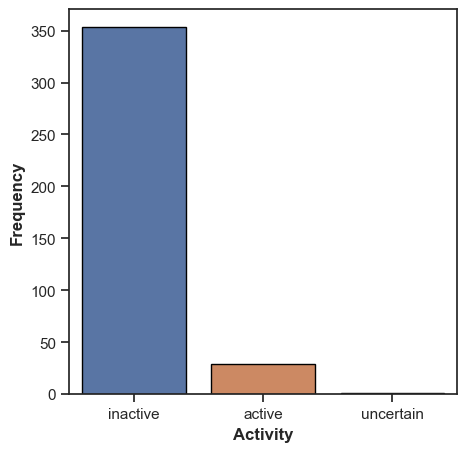

In [9]:
# display frequency plot
plt.figure(figsize=(5, 5))

sns.countplot(x='activity_comment', data=df_combined, edgecolor='black')

plt.xlabel('Activity', fontsize= 12, fontweight='bold')
plt.ylabel('Frequency', fontsize= 12, fontweight='bold')

#### Key Observation:
The dataset is **dominated by inactive compounds**, with over 600 entries marked as "inactive". It is clearly imbalanced between these two category. Therefore, the small portion of "active" compounds in the dataset is biologically expected since most compounds tested in assay are expected to be inactive, as only a few would show strong inhibition or active against the target protein.

### 3.2 Scatter plot MW vs logP

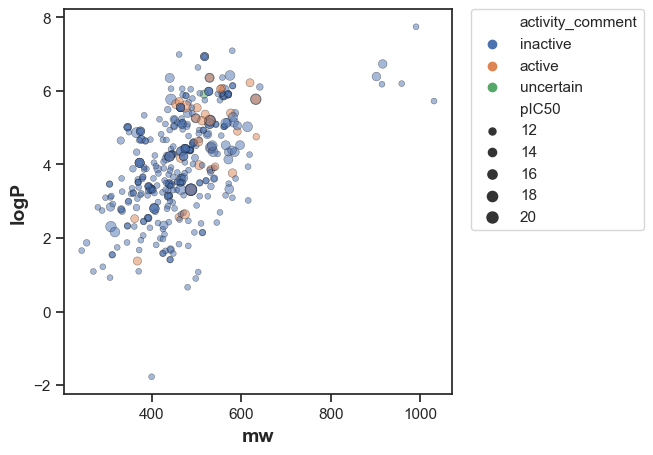

In [10]:
# display scatter plot
plt.figure(figsize=(5,5))

sns.scatterplot(x='mw', y='logP', data=df_combined, hue='activity_comment', size='pIC50', edgecolor='black', alpha=0.5)

plt.xlabel('mw', fontsize=14, fontweight='bold')
plt.ylabel('logP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

#### Key Observation:
- Most of the compounds fall within the molecular weight range of 400-700 Daltons, with only a few outliers exceeding 1000 Daltons.
- Compounds are primarily clustered around LogP value between 2 and 6, indicating that the majority have moderate lipophilicity.
- Active compounds(orange dot) are relatively more concentrated around 400 - 700 and LogP values 4-6. This is biologically relevant because compounds that follow Lipinski's rule of five(moderate MW and LogP) are more likely to be orally active drugs.
- There are very few uncertain compounds, and they fall in the moderate MW and LogP range as well.
- Larger dots indicate higher pIC50 values are generally found in the central region which suggest that compounds with moderate molecular weight and lipophilicity tend to be more potent.
- There may be a week negative correlation between molecular weight and activity as heavier compoounds tend to cluster as inactive
- LogP does not show a strong direct relationship with activity, but very high or very low values of LogP coud negatively affect the bioactivity of the compounds.

### 3.3 Box plots

#### 3.3.1 pIC50 values

Text(0, 0.5, 'pIC50 value')

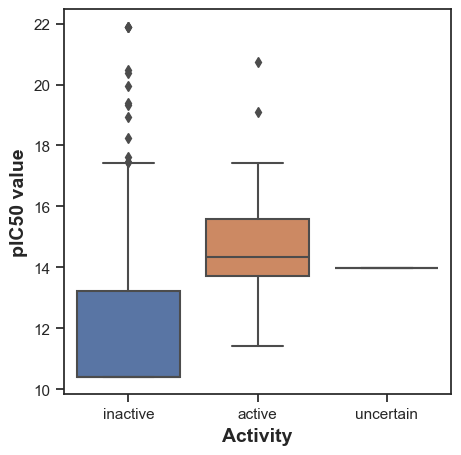

In [11]:
# Display boxplot pIC50
plt.figure(figsize=(5,5))

sns.boxplot(x='activity_comment', y='pIC50', data= df_combined)

plt.xlabel('Activity', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

#### Statistical Analysis | Mann-Whitney U Test
Statistical analysis will be perform to look up the difference between inactive and active class.

In [12]:
# Define man-whitney u test function
def manwhitney(descriptor, df, alpha=0.05, verbose=False):
    '''
    Mann-Whitney U test for descriptor distribution between active and inactive classes.
    
    Parameters:
    - descriptor(str): Column name to test.
    - df (pd.DataFrame): DataFrame with descriptor and activity_comment
    - alpha(float): Significance level (default 0.05)
    - verbose (bool): If True, print results.
    
    Return:
    - pd.DataFrame: Test results with statistics and interpretation.
    '''
    from scipy.stats import mannwhitneyu
    
    # Select relevant columns
    df_selected = df[[descriptor, 'activity_comment']]
    
    # Separate dataset based on activity comment
    active = df_selected[df_selected['activity_comment'] == 'active'][descriptor]
    inactive = df_selected[df_selected['activity_comment'] == 'inactive'][descriptor]
    
    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(active, inactive)
    
    # Interpret the result
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'
    
    
    # Create a dataframe for the results
    results = pd.DataFrame({
        'Descriptor': [descriptor],
        'Statistics': [stat],
        'p-value': [p],
        'Alpha': [alpha],
        'Interpretation': [interpretation]
    })
    
    # Save the result to csv
    filename = f'mannwhitneyu_{descriptor}.csv'
    results.to_csv(filename, index=False)
    
    # Print detailed output if verbose is True
    if verbose:
        print(f'Mann-Whitney U test for {descriptor}:')
        print(f'Statistics: {stat:.3f}, p-value: {p:.3f}')
        print(f'Interpretation: {interpretation}')
    
    return results

In [13]:
# statistical analysis pIC50
manwhitney('pIC50', df_combined)

,Descriptor,Statistics,p-value,Alpha,Interpretation
0,pIC50,8485.5,9.775309e-11,0.05,Different distribution (reject H0)


#### Insight and Interpretation
- The pIC50 values of inactive compounds shows a wide range with more variability compraed to the active compounds.
- The distribution of pIC50 values active compounds is generally higher and more concentrated, which implies that active compoounds tend to have higher pIC50 compared to inactive ones.
- The results indicate that pIC50 values, which reflect the biological activity of the compounds, are significantly different between active and inactive compounds. Active compounds tend to have higher pIC50 values (indicative of higher potency).

#### 3.3.2 MV values

Text(0, 0.5, 'MW value')

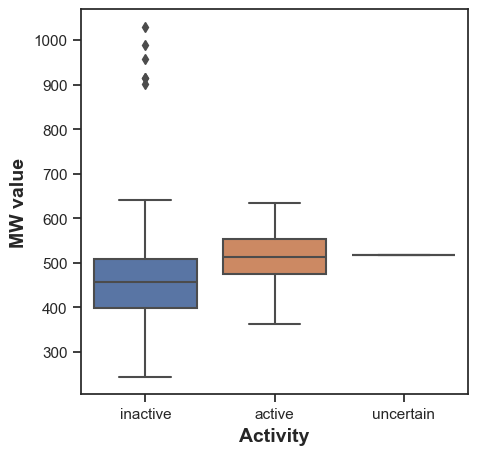

In [14]:
# Display boxplot mw
plt.figure(figsize=(5,5))

sns.boxplot(x='activity_comment', y='mw', data= df_combined)

plt.xlabel('Activity', fontsize=14, fontweight='bold')
plt.ylabel('MW value', fontsize=14, fontweight='bold')

#### Statistical Analysis | Mann-Whitney U Test

In [15]:
# statistical analysis mw
manwhitney('mw', df_combined)

,Descriptor,Statistics,p-value,Alpha,Interpretation
0,mw,7287.5,0.000148,0.05,Different distribution (reject H0)


#### Insight and Interpretation
- The MW values of inactive compounds have a wider range of molecular weight values with some outliers above 900, on the other hand, the MW values of active compounds show a slightly more concentrated range with median slightly above 500 and there are no extreme outliers visiable.
- The distribution of MW values between inactive and active compounds swhos a signigicant difference. Active compounds seem to have higher MW values.

#### 3.3.3 LogP values

Text(0, 0.5, 'LogP value')

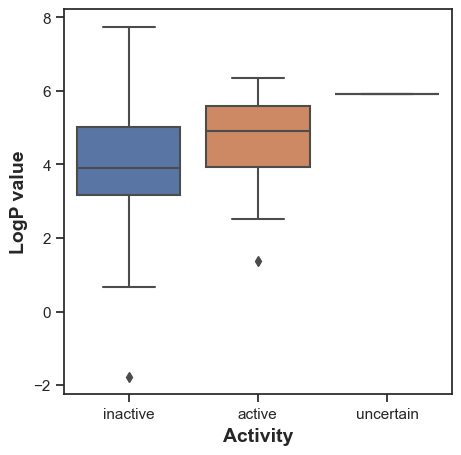

In [16]:
# Display boxplot logP
plt.figure(figsize=(5,5))

sns.boxplot(x='activity_comment', y='logP', data= df_combined)

plt.xlabel('Activity', fontsize=14, fontweight='bold')
plt.ylabel('LogP value', fontsize=14, fontweight='bold')

#### Statistical Analysis | Mann-Whitney U Test

In [17]:
# statistical analysis logP
manwhitney('logP', df_combined)

,Descriptor,Statistics,p-value,Alpha,Interpretation
0,logP,6665.5,0.006819,0.05,Different distribution (reject H0)


#### Insight and Interpretation
- The distribution of logP of inactive compounds and active compounds have different distribution based on statstical analysis. The distribution of inactive counds seem wider, with logP values ranging from around 1 to 7 and median around 4.
- The distribution logP of active compounds is slightly narrower with values between 3 to 6 and median logP is around 5.
- The logP values for active compounds are generally higher compared to inactive compounds. This suggests that more hydrophobic (higher LogP) compounds might have a higher likelihood of being active, though the range still overlaps with inactive compounds.

#### 3.3.4 NumHDonors values

Text(0, 0.5, 'NumHDonors value')

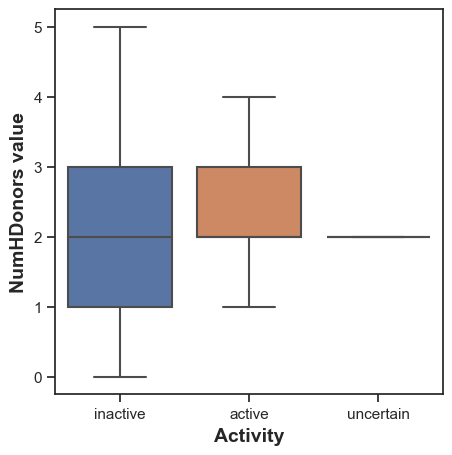

In [18]:
# Display boxplot numHdonors
plt.figure(figsize=(5,5))

sns.boxplot(x='activity_comment', y='numHdonors', data= df_combined)

plt.xlabel('Activity', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors value', fontsize=14, fontweight='bold')

#### Statistical Analysis | Mann-Whitney U Test

In [19]:
# statistical analysis numHdonors
manwhitney('numHdonors', df_combined)

,Descriptor,Statistics,p-value,Alpha,Interpretation
0,numHdonors,5854.0,0.174657,0.05,Same distribution (fail to reject H0)


#### Insight and Interpretation
- Since the p-value is greater than the alpha(0.05), we fail to reject the null hypothesis(HO), which is indicates that there is no significant difference in the distribution of hydrogen bond donors across the activity classes.
- The distribution of NumHDonors values for inactive compounds appears more spread out compraed to active compounds but almost have similar median around 2, though inactive compounds exhibit more variability.
- The number of hydrogen bonds donor doesn't seen to strongly correlate with compound activity in this dataset, since the distribution is similar across active and inactive compounds.

#### 3.3.5 NumHAcceptors values

Text(0, 0.5, 'NumHAcceptors value')

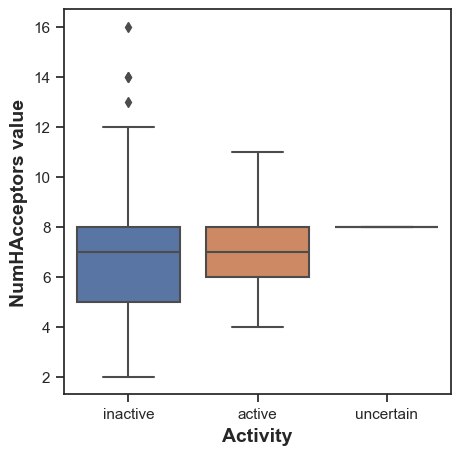

In [20]:
# Display boxplot numHacceptors
plt.figure(figsize=(5,5))

sns.boxplot(x='activity_comment', y='numHacceptors', data= df_combined)

plt.xlabel('Activity', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors value', fontsize=14, fontweight='bold')

#### Statistical Analysis | Mann-Whitney U Test

In [21]:
# statistical analysis numHacceptors
manwhitney('numHacceptors', df_combined)

,Descriptor,Statistics,p-value,Alpha,Interpretation
0,numHacceptors,6093.5,0.083773,0.05,Same distribution (fail to reject H0)


#### Insight and Interpretation
- Since the p-value is greater than the alpha(0.05), we fail to reject the null hypothesis(HO), which is indicates that there is no significant difference in the distribution of hydrogen bond acceptors across the activity classes.
- The distribution of NumHAcceptors values for inactive compounds appears more spread out with several outlier above 13 compared to active compounds but almost have similar median around 7, though inactive compounds exhibit more variability.
- The number of hydrogen bonds acceptor doesn't seen to strongly correlate with compound activity in this dataset, since the distribution is similar across active and inactive compounds.

## 4. Data Pre-Processing

### 4.1 Feature Selection

Firstly, I will check the information inside columns which is suspect to contain few single or  variable: `assay_type`, `bao_format`, `qudt_units`, `standard_flag`, `standard_type`, `target_chembl_id`, `target_organism`, `target_pref_name`, `target_tax_id`, `units`, `uo_units`, `entry`, `entry_name`, `protein_names`, `organism`, `length`, and `sequence`. 

In [22]:
# List of selected columns
selected_columns = [
    'qudt_units', 'standard_flag', 
    'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id',
    'units', 'uo_units', 'entry', 'entry_name', 'protein_names', 'organism', 
    'length', 'sequence', 'standard_units'
]

# Check unique values for each selected column
unique_values = {col: df_combined[col].nunique() for col in selected_columns}

# Print unique values for each column
for col, unique_count in unique_values.items():
    print(f'Column: {col} - Unique Values: {unique_count}')
    print(df[col].value_counts(dropna=False).head())  # Print top 5 unique values, including NaN if any
    print('---')


Column: qudt_units - Unique Values: 1
qudt_units
http://www.openphacts.org/units/Nanomolar    383
Name: count, dtype: int64
---
Column: standard_flag - Unique Values: 1
standard_flag
1    383
Name: count, dtype: int64
---
Column: target_chembl_id - Unique Values: 1
target_chembl_id
CHEMBL4223    383
Name: count, dtype: int64
---
Column: target_organism - Unique Values: 1
target_organism
Homo sapiens    383
Name: count, dtype: int64
---
Column: target_pref_name - Unique Values: 1
target_pref_name
Tyrosine-protein kinase FRK    383
Name: count, dtype: int64
---
Column: target_tax_id - Unique Values: 1
target_tax_id
9606    383
Name: count, dtype: int64
---
Column: units - Unique Values: 1
units
nM    383
Name: count, dtype: int64
---
Column: uo_units - Unique Values: 1
uo_units
UO_0000065    383
Name: count, dtype: int64
---
Column: entry - Unique Values: 1
entry
P42685    383
Name: count, dtype: int64
---
Column: entry_name - Unique Values: 1
entry_name
FRK_HUMAN    383
Name: count, dty

These column only contain few uniques values(lower than 5) and most of them only contain single values in each columns. So I will drop these colum from my main dataset.

In [23]:
# Drop the identified columns from the dataframe
df_dropped = df_combined.drop(columns=selected_columns, axis=1)

# Print the columns that were dropped
print("Dropped columns:", selected_columns)

# Optional: Check the resulting dataframe shape
print(f"New dataframe shape: {df_dropped.shape}")

Dropped columns: ['qudt_units', 'standard_flag', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'units', 'uo_units', 'entry', 'entry_name', 'protein_names', 'organism', 'length', 'sequence', 'standard_units']
New dataframe shape: (383, 31)


Secondly, I check the correlation between feature using *correlation matrix*.

In [54]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           383 non-null    object 
 1   activity_id                383 non-null    int64  
 2   activity_properties        383 non-null    object 
 3   assay_chembl_id            383 non-null    object 
 4   assay_description          383 non-null    object 
 5   assay_type                 383 non-null    object 
 6   bao_endpoint               383 non-null    object 
 7   bao_format                 383 non-null    object 
 8   bao_label                  383 non-null    object 
 9   canonical_smiles_x         383 non-null    object 
 10  document_chembl_id         383 non-null    object 
 11  document_journal           383 non-null    object 
 12  molecule_chembl_id         383 non-null    object 
 13  molecule_pref_name         383 non-null    object 

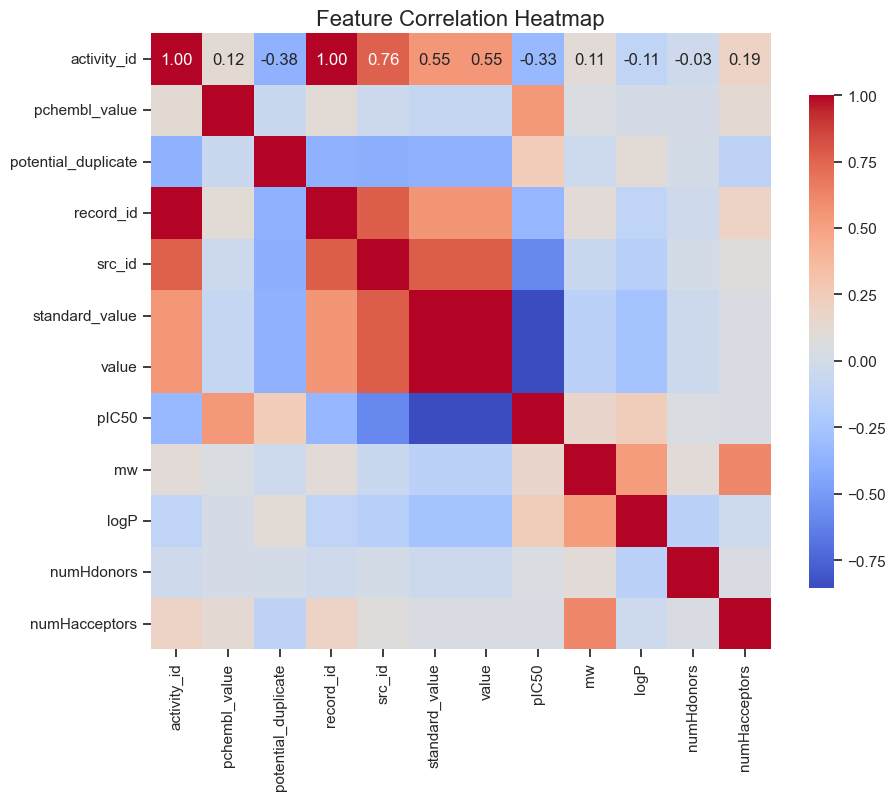

In [58]:
# Calculate the correlation matrix
numeric_df = df_dropped.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, 
            fmt=".2f",
            cmap='coolwarm',     
            cbar_kws={"shrink": .8})

# Set the title
plt.title('Feature Correlation Heatmap', fontsize=16)

# Show the plot
plt.show()

**Insight:**
Based on the correlation matrix above, it shows that the `pIC50` as the target has a high correlation to `pchembl_value` and `standard_value`, which makes sense since the `pIC50` values were calculate from `standard_value`, and it's showing that `standard_value` has a very high correlation with `value` so I will drop both columns from the feature dataset as well as another unnecessary column.

In [71]:
# Drop target and unnecessary columns for feature
X = df_dropped.drop(['pIC50', 'pchembl_value', 'standard_value', 'value', 'activity_id',  'activity_properties', 'assay_chembl_id', 'bao_format', 'parent_molecule_chembl_id', 'standard_type',
                      'assay_description', 'document_chembl_id', 'molecule_chembl_id', 'canonical_smiles_x', 'canonical_smiles_y', 'document_journal', 'molecule_pref_name'], axis=1)

In [72]:
# Keep target separately
y = df_dropped['pIC50']

### 4.2 Data Encoding and Normalization

In [73]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Encoding categorical columns
categorical_columns = ['activity_comment', 'assay_type', 'bao_endpoint', 'bao_label', 'relation', 'standard_relation' ]  # categorial columns to encode
onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # dropping first to avoid multicollinearity
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_columns]), columns=onehot_encoder.get_feature_names_out())

# Normalize numerical features (excluding categorical columns)
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X[numerical_columns]), columns=numerical_columns)

# Concatenate the normalized and encoded columns
X_preprocessed = pd.concat([X_normalized, X_encoded], axis=1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [74]:
# Display the first few rows of the encoded data
print(X_encoded.head())

# Check if the shape matches the expected number of columns after encoding
print(f"Shape of encoded categorical data: {X_encoded.shape}")

   activity_comment_inactive  activity_comment_uncertain  assay_type_B  \
0                        1.0                         0.0           1.0   
1                        1.0                         0.0           1.0   
2                        1.0                         0.0           1.0   
3                        1.0                         0.0           1.0   
4                        1.0                         0.0           1.0   

   bao_endpoint_BAO_0000190  bao_endpoint_BAO_0000192  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   bao_label_cell-based format  bao_label_single protein format  \
0                          0.0                              1.0   
1                          0.0                              1.0   
2          

In [68]:
# Check the shape and first few rows of the preprocessed dataset
print(f"Shape of preprocessed data: {X_preprocessed.shape}")
print(X_preprocessed.head())

Shape of preprocessed data: (383, 18)
   pchembl_value  potential_duplicate  record_id    src_id        mw  \
0      -0.288968             2.849394  -2.332247 -1.366821 -0.012081   
1       3.061540            -0.350952  -2.228576 -1.366821 -1.591939   
2       0.701773            -0.350952  -2.228575 -1.366821 -0.258463   
3       2.521136            -0.350952  -2.218960 -1.366821 -1.007803   
4      -0.216914            -0.350952  -2.170486 -1.366821 -0.920862   

       logP  numHdonors  numHacceptors  activity_comment_inactive  \
0  1.104800    0.976969      -1.329198                        1.0   
1 -1.260625    0.976969      -0.317105                        1.0   
2  1.690420   -0.080034      -2.341291                        1.0   
3  0.603921   -0.080034      -1.329198                        1.0   
4  0.632986    2.033972      -1.835244                        1.0   

   activity_comment_uncertain  assay_type_B  bao_endpoint_BAO_0000190  \
0                         0.0           1

In [75]:
# Check for missing values in the preprocessed data
print(f"Missing values in preprocessed data: {X_preprocessed.isnull().sum().sum()}")

Missing values in preprocessed data: 0


Data preprocessing is successfully done.

### Exporting Dataset to Csv

Finally, I will be exporting feature and target then download it as .csv file format.

In [76]:
# Export the feature to a CSV file
X_preprocessed.to_csv('feature.csv', index=False)

# Export the target to a CSV file
y.to_csv('target.csv', index=False)

print('Export Succeed')

Export Succeed


# Reference

1. Lipinski, C. A., Lombardo, F., Dominy, B. W., & Feeney, P. J. (2001). Experimental and Computational Approaches to Estimate Solubility and Permeability in Drug Discovery and Development Settings. Advanced Drug Delivery Reviews, 46(1-3), 3-26. [https://doi.org/10.1016/S0169-409X(00)00129-0]